# Import

In [1]:
import math
from pathlib import Path
import sys, shutil

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multyadding  
    sys.path.append("../scripts/") 
# types
import re
import glob

# work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

import keras
import tensorflow as tf
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras import layers
from tensorflow.keras.initializers import random_uniform, glorot_uniform

# my scripts
from build_model import data_augmenter, create_MobNetLike, create_ResNet2, ConfusingMatrixLog
from data_handle import data_dir, read_configuration, read_data

In [2]:
%load_ext tensorboard

In [3]:
configuration = read_configuration(data_dir / "config.yaml")

# Load train and test sets

In [4]:
INPUT, PATHS, EMOTIONS = configuration['input'], configuration['paths'], configuration['emotions']

In [5]:
input_shape = (INPUT['img_width'], INPUT['img_height'], 1)

## Read data

In [6]:
X_train, y_train_orig = read_data(data_dir / "train.csv", img_size=INPUT['img_width'], out_dtype=INPUT['img_dtype'])
X_test, y_test_orig = read_data(data_dir / "test_with_emotions.csv", img_size=INPUT['img_width'], out_dtype=INPUT['img_dtype'])

## Statistic

In [7]:
print('***X_train***')
print (f"number of training examples = {str(X_train.shape[0])} (shape={X_train.shape})")
print(f"type of items: {X_train.dtype}\ntakes {round(X_train.nbytes/1024/1024, 2)}Mb")
print('***X_test***')
print (f"number of test examples = {str(X_test.shape[0])} (shape={X_test.shape})")
print(f"shape={X_test.shape}\ntype of items: {X_test.dtype}\ntakes {round(X_test.nbytes/1024/1024, 2)}Mb")

***X_train***
number of training examples = 28709 (shape=(28709, 48, 48, 1))
type of items: float32
takes 252.33Mb
***X_test***
number of test examples = 7178 (shape=(7178, 48, 48, 1))
shape=(7178, 48, 48, 1)
type of items: float32
takes 63.09Mb


## Plot distribution

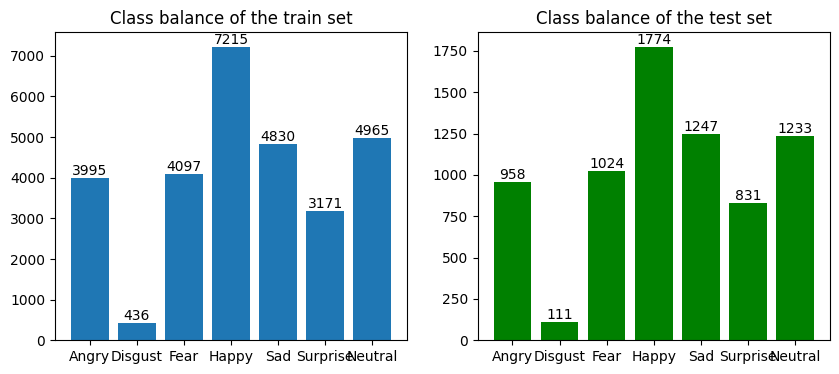

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
rect_tr = ax[0].bar(EMOTIONS, np.bincount(y_train_orig)) #bincount() only works with non-negative integers
ax[0].bar_label(rect_tr)
ax[0].set_title('Class balance of the train set')

rect_ts = ax[1].bar(EMOTIONS, np.bincount(y_test_orig), color='g')
ax[1].bar_label(rect_ts)
ax[1].set_title('Class balance of the test set')
plt.show()

## Balance the distribution of input data

In [9]:
def get_max_class_nsamples(X: pd.DataFrame, y:pd.Series) ->dict:
    """
    Returns the maximum number of samples of a class and the class index.
    :param X: an array of shape (n_samples, ...)
    :param y: an array of shape (n_samples,), it must consist of class labels.
    :return: the maximum number of samples of a class and the class index.
    """
    labels = set(y)
    max_nsamples = {'num':0, 'class':-1}
    for label in labels:
        nsamples = X[y == label].shape[0] 
        if nsamples > max_nsamples['num']:
            max_nsamples['num'] = nsamples
            max_nsamples['class'] = label
    return max_nsamples, labels


In [10]:
max_samples, classes = get_max_class_nsamples(X_train, y_train_orig)
k=0.75
samples =[]
labels=[]
for class_ in classes:
    if class_==max_samples['class']:
        continue
    Xx = X_train[y_train_orig == class_]
    yy = y_train_orig[y_train_orig == class_]
    X_upsampled, y_upsampled = resample(Xx, yy,
                                        replace=True,
                                        n_samples=int(k*(max_samples['num']-len(yy))),
                                        )
    samples.append(X_upsampled)
    labels.append(y_upsampled)

# unite upsampled sets to the origin sets
X_train_balanced = np.vstack([X_train, *samples])
y_train_balanced = np.hstack([y_train_orig, *labels])


In [11]:
k_small = 0.5
samples_small = round(k_small * max_samples['num'], 0)
samples =[]
labels=[]
for class_ in classes:
    nsamples = X_train[y_train_orig == class_].shape[0]
    Xx = X_train[y_train_orig == class_]
    yy = y_train_orig[y_train_orig == class_]
    if Xx.shape[0] > samples_small:
        replace = False
    else:
        replace = True 
    X_upsampled_small, y_upsampled_small = resample(Xx, yy,
                                        replace=replace,
                                        n_samples=int(samples_small),
                                        )
    samples.append(X_upsampled_small)
    labels.append(y_upsampled_small)

# unite upsampled sets to the origin sets
X_train_balanced_small = np.vstack(samples)
y_train_balanced_small = np.hstack(labels)



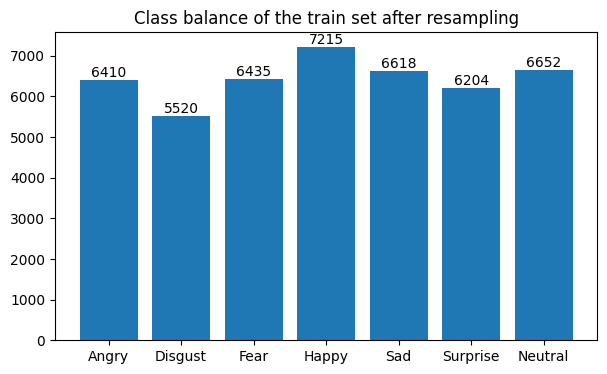

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))
rect_tr = plt.bar(EMOTIONS, np.bincount(y_train_balanced)) 
ax.bar_label(rect_tr)
ax.set_title('Class balance of the train set after resampling')
plt.show()

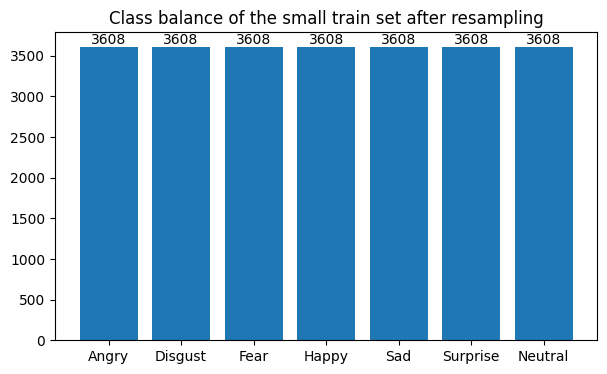

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))
rect_tr = plt.bar(EMOTIONS, np.bincount(y_train_balanced_small)) 
ax.bar_label(rect_tr)
ax.set_title('Class balance of the small train set after resampling')
plt.show()

## Convert training and test labels to one-to-hot

In [14]:
lb = LabelBinarizer()
y_train_onehot = lb.fit_transform(y_train_balanced)
y_train_onehot_small = lb.fit_transform(y_train_balanced_small)
y_test_onehot = lb.transform(y_test_orig)
print("Y classes: ", lb.classes_)

Y classes:  [0 1 2 3 4 5 6]


In [15]:
# Save y_test_onehot to a file for use in another module
np.save(PATHS['res_dir'] / 'X_test.npy', X_test)
np.save(PATHS['res_dir'] / 'y_test_onehot.npy', y_test_onehot)
print(f'y_test_onehot saved to {PATHS['res_dir'] / "y_test_onehot.npy"}')
print(f'X_test saved to {PATHS['res_dir'] / "X_test.npy"}')

y_test_onehot saved to ..\results\y_test_onehot.npy
X_test saved to ..\results\X_test.npy


## Make train and test datasets

In [16]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_onehot))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot))
ds_train_small = tf.data.Dataset.from_tensor_slices((X_train_balanced_small, y_train_onehot_small))

In [17]:
ds_train = ds_train.shuffle(ds_train.cardinality(), reshuffle_each_iteration=True).batch(INPUT['batch_size'], num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)
ds_train_small = ds_train_small.shuffle(ds_train_small.cardinality(), reshuffle_each_iteration=True).batch(INPUT['batch_size'], num_parallel_calls=tf.data.AUTOTUNE)
ds_train_small = ds_train_small.prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(INPUT['batch_size'])

## Output some pictures

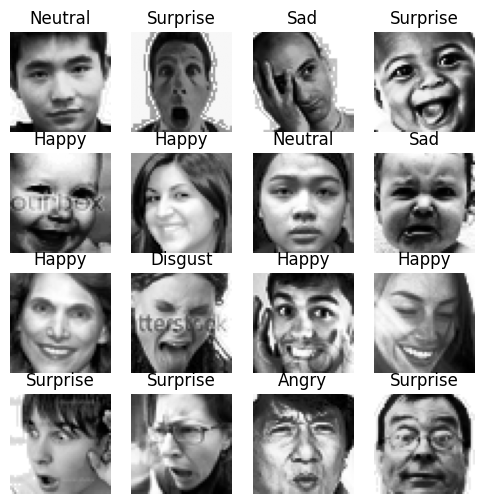

In [18]:
offset=2
plt.figure(figsize=(6, 6))
nm=4
i=0
for image, label in ds_train.skip(offset).unbatch().take(nm*nm):
    ax = plt.subplot(nm, nm, i + 1)
    plt.imshow(image.numpy(), cmap='gray')
    plt.title(EMOTIONS[label.numpy().argmax()])
    plt.axis("off")
    i+=1

# Create and run

## Function to compile models

In [19]:
COMPILE_CFG = configuration['compile']
init_learning_rate = COMPILE_CFG['optimizer']['learning_rate']

In [20]:
def compile(model, optimizer_cfg=COMPILE_CFG['optimizer'], learning_rate=init_learning_rate, loss=COMPILE_CFG['loss'], metrics=COMPILE_CFG['metrics']):
    optimizer_cfg['learning_rate'] = learning_rate
    optimizer = tf.keras.optimizers.get(optimizer_cfg['name']).from_config(optimizer_cfg)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model.summary()
 

## Create models

In [21]:
MODEL_CFG = configuration['model']

In [22]:
data_augmentation = data_augmenter()

In [23]:
model_mob = create_MobNetLike(input_shape=input_shape, classes=INPUT['num_classes'], data_augmentation=data_augmentation, 
                        kernel_regularizer=tf.keras.regularizers.l2(MODEL_CFG['reg_l2']),
                        **MODEL_CFG['mobnet'],
                        name='model_mob')
model_resnet2=create_ResNet2(input_shape=input_shape, classes=INPUT['num_classes'], data_augmentation=data_augmentation, 
                             kernel_regularizer=tf.keras.regularizers.l2(MODEL_CFG['reg_l2']),
                             **MODEL_CFG['resnet2'],
                            name='model_resnet2')

In [24]:
main_model_name = 'MobNetLike'
models={
        main_model_name: {'model': model_mob, 'epochs': 40}, 
        #'ResNet2_v2': {'model': model_resnet2, 'epochs': 40}
        }

## Compile

In [25]:
learning_rate=init_learning_rate*0.1
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=math.ceil(X_train.shape[0]//INPUT['batch_size']),
  decay_rate=0.98,
  staircase=False)

In [26]:
for model in models.values():
    compile(model=model['model'], learning_rate=init_learning_rate*0.02)#learning_rate=lr_schedule)

Model: "model_mob"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 48, 48, 1) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_conv        │ (None, 24, 24,    │        160 │ sequential[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_BN          │ (None, 24, 24,    │         64 │ initial_conv[0][… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_relu        │ (None, 24, 24,    │          0 │ initial_BN[0][0]  │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand1 (Conv2D)    │ (None, 24, 24,    │        816 │ initial_relu[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_BN1          │ (None, 24, 24,    │        192 │ expand1[0][0]     │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dropout1     │ (None, 24, 24,    │          0 │ expand_BN1[0][0]  │
│ (Dropout)           │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_relu1        │ (None, 24, 24,    │          0 │ expand_dropout1[… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise1          │ (None, 24, 24,    │        480 │ expand_relu1[0][… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_BN1       │ (None, 24, 24,    │        192 │ depthwise1[0][0]  │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_relu1     │ (None, 24, 24,    │          0 │ depthwise_BN1[0]… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pointwise1 (Conv2D) │ (None, 24, 24,    │        784 │ depthwise_relu1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pointwise_BN1       │ (None, 24, 24,    │         64 │ pointwise1[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pointwise_dropout1  │ (None, 24, 24,    │          0 │ pointwise_BN1[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ pointwise_dropou… │
│                     │ 16)               │            │ initial_relu[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand2 (Conv2D)    │ (None, 24, 24,    │      1,360 │ add[0][0]       

 Total params: 11,185,559 (42.67 MB)

 Trainable params: 11,147,447 (42.52 MB)

 Non-trainable params: 38,112 (148.88 KB)

## Fit

In [27]:
CHECKPOINT_PREFIXES = configuration['checkpoint_prefixes']

### Functions to create callbacks 

In [28]:
# Define the per-epoch callback.
def create_callbacks(early_stopping=True, checkpoint_dir=PATHS['checkpoint_dir'], tensorboard_dir=None, confusing_matrix=True, reduce_lr=True):
    """
    create a list of TensorFlow callbacks
    
    :param model_name: string, the name of the trained model to use in logs' directories names
    :param early_stopping: boolean, whether to use TensorFlow EarlyStopping callback 
    :param checkpoint_dir: None or string or Path object, if not None, it specifies path of the directory where to save the checkpoint files created by TensorFlow ModelCheckpoint callback. If it is None, the TensorFlow ModelCheckpoint callback will not be created
    :param tensorboard_dir: None or string or Path object, if not None, it specifies path of the directory to be used as log_dir parameter by TensorFlow TensorBoard callback (to keep summary files). If it is None, the TensorFlow TensorBoard callback will not be created
    :param confusing_matrix: boolean, whether to use ModelCheckpoint callback. If tensorboard_dir is None it will not be used. 
    :param reduce_lr: boolean, whether to use TensorFlow ReduceLROnPlateau callback.
    
    :return: list of TensorFlow callbacks
    """ 
    callbacks = []
    if early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=10, 
                                                      #restore_best_weights=True, 
                                                      start_from_epoch=10))
    if checkpoint_dir is not None:
        checkpoint_format_name= '-E{epoch:04d}--val_acc{val_accuracy:.4f}--val_loss{val_loss:.4f}'
        filepath=Path(checkpoint_dir) / f'{CHECKPOINT_PREFIXES['weights']}{checkpoint_format_name}.weights.h5'
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy', 
                                            mode='max',  
                                            save_best_only=True,
                                            initial_value_threshold=0.4))
        
        filepath=Path(checkpoint_dir) / f'{CHECKPOINT_PREFIXES['weights']}{checkpoint_format_name}.keras'
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath,
                                            save_weights_only=False,
                                            monitor='val_accuracy', 
                                            mode='max',  
                                            save_best_only=True,
                                            initial_value_threshold=0.5))
    
    if tensorboard_dir is not None:
        callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))
        # log confusion matrix only if the tensorboard_dir is given
        if confusing_matrix:
            dir_path=Path(tensorboard_dir, 'confusing_matrix')
            callbacks.append(ConfusingMatrixLog(X_test, y_test_orig,class_names=EMOTIONS,log_dir=str(dir_path))) # turn directory to string, because Path object does not work with tf.summary.create_file_writer()
    
    if reduce_lr:        
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3, min_delta=0.001, verbose=1))
    return callbacks

### Functions to load from the previous fits

In [29]:
def get_val_acc_from_name(filename):
    val_acc_re = r'(?<=acc0.)\d+'
    match = re.search(val_acc_re, filename)
    if match:
        return int(match.group(0))
    else:
        return 0

def get_val_loss_from_name(filename):
    val_loss_re = r'(?<=loss)\d+.\d+'
    match = re.search(val_loss_re, filename)
    if match:
        return float(match.group(0))
    else:
        return 0
    
def get_epoch_from_name(filename):
    epoch = r'(?<=-E)\d+'
    match = re.search(epoch, filename)
    if match:
        return int(match.group(0))
    else:
        return 0
    

In [30]:
def load_from_checkpoint(model, model_checkpoint_dir, weights_only=True, acc=None, epoch=None):
    if weights_only:
        files = glob.glob(CHECKPOINT_PREFIXES['weights']+'*' ,root_dir=model_checkpoint_dir)
    else:
        files = glob.glob(CHECKPOINT_PREFIXES['model']+'*' ,root_dir=model_checkpoint_dir)
    best_file = ''
    val_acc = 0
    found = False
    for file in files:
        if epoch is not None:
            tmp_e = get_epoch_from_name(file)
            if tmp_e==epoch:
                best_file = file
                found = True
                break
    
        tmp = get_val_acc_from_name(file)
        if epoch is None and acc is not None and tmp == acc:
            best_file = file
            found = True
            break
            
        # search for the file with the highest accuracy
        if tmp > val_acc:
            val_acc = tmp
            best_file = file
    
    if best_file == '':
        print('No checkpoint found')
        return model
    
    def log_if_not_found():
        if found:
            return
        if epoch is not None:
            print(f'no file of epoch {epoch} found')
            return 
        if acc is not None:
            print(f'no file with {acc} accuracy found')
            return 
            
    if weights_only:
        log_if_not_found()
        print('load weights from {}'.format(best_file))
        model.load_weights(Path(model_checkpoint_dir,best_file),skip_mismatch=True)
    else:
        log_if_not_found()
        print('load model from {}'.format(best_file))
        model = tf.keras.models.load_model(Path(model_checkpoint_dir,best_file))
    return model

### Load weights from previous fits

In [31]:
subdir = 'v2_dropout0_1'  

In [32]:
#to_load = ['model_resnet50_half_filters', 'model_resnet2', 'model_CNN_relu']  

for model_name, model_dict in models.items():
    print(f'loading {model_name}')
    model_dict['model'] = load_from_checkpoint(model_dict['model'], PATHS['checkpoint_dir'] / model_name / subdir, weights_only=False, epoch=76)
    print('=============================================')

loading MobNetLike
no file of epoch 76 found
load model from cp_model-E0261--val_acc0.6656--val_loss1.2314.keras


### Fit

In [33]:
history = {}
# for  model in models.values():
#     model['epochs'] = 14
models[main_model_name]['initial_epoch'] = 260
# models['ResNet2_v2']['initial_epoch'] = 1582
models[main_model_name]['epochs'] = 0
# models['ResNet2_v2']['epochs'] = 0

class_weight={0: 1.1, 1: 1.2, 2: 1.2, 3: 1., 4: 1.2, 5: 1., 6: 1.}#{0: 1.2, 1: 1.9, 2: 1.3, 3: 1., 4: 1.2, 5: 1., 6: 1.1}

for name, model in models.items():
    model_tensorboard_dir=PATHS['log_dir'] / name / subdir
    model_checkpoint_dir=PATHS['checkpoint_dir'] / name / subdir
    callbacks=create_callbacks(early_stopping=False, checkpoint_dir=model_checkpoint_dir, tensorboard_dir=model_tensorboard_dir, confusing_matrix=True, reduce_lr=True)
    initial_epoch=model['initial_epoch']
    
    history[name] = model['model'].fit(ds_train,
                                       initial_epoch=initial_epoch,
                                       epochs=initial_epoch+model['epochs'],
                                       validation_data=ds_test,
                                       class_weight=class_weight,
                                       callbacks=callbacks)
   

In [34]:
model_tensorboard_dir

WindowsPath('logs/MobNetLike/v2_dropout0_1')

## Save the model to file

In [35]:
model_checkpoint_dir, main_model_name

(WindowsPath('checkpoints/MobNetLike/v2_dropout0_1'), 'MobNetLike')

In [36]:
model_file = PATHS['res_dir'] / 'final_emotion_model.keras'
files = glob.glob(CHECKPOINT_PREFIXES['model']+'*' ,root_dir=model_checkpoint_dir)
best_file = ''
val_acc = 0
found = False
for file in files:
    tmp = get_val_acc_from_name(file)
    if tmp > val_acc:
        val_acc = tmp
        best_file = file

if best_file:
    shutil.copy(model_checkpoint_dir / best_file, model_file)
    print(f'Copied {best_file} to {model_file.resolve()}')
else:
    print('No file to copy')

Copied cp_model-E0261--val_acc0.6656--val_loss1.2314.keras to C:\Users\alena\AI\emotions-detector\results\final_emotion_model.keras


In [37]:
model = models[main_model_name]['model']
summary_file = PATHS['res_dir'] / 'final_emotion_model_arch.txt'
with open(summary_file, 'w', encoding="utf-8") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f'Model summary saved to {summary_file.resolve()}')

Model summary saved to C:\Users\alena\AI\emotions-detector\results\final_emotion_model_arch.txt


# Quanization

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_model = converter.convert()

model_file = PATHS['tflite_model_path']
with open(model_file, 'wb') as f:
    f.write(quant_model)
print(f'Quantized model saved to {model_file.resolve()}')

INFO:tensorflow:Assets written to: C:\Users\alena\AppData\Local\Temp\tmpkpxx75dt\assets


INFO:tensorflow:Assets written to: C:\Users\alena\AppData\Local\Temp\tmpkpxx75dt\assets


Saved artifact at 'C:\Users\alena\AppData\Local\Temp\tmpkpxx75dt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2278716205648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716206032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716206224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716207184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716206800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716207952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716206416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716209296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716209680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278716206992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  227871